In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(130298)

In [2]:
%pwd

'/Users/annachiararossi/Documents/Healthcare data/heart-failure-project'

# Dataset importing and NAs identification

Looking at the variables one at a time, in the notebook "1_Data preprocessing and cleaning", we highlighted some values which were likely miswritten. We identified the value 'Unknown' to be recognized as a missing value and same for all patients for which a value of 0 was reported, where it is not physically possible. Also some unlikely values in weight and height will be substituted by missing values, as they represent biased information. For more detailed explanations on these choices, see the notebook previously cited.

In [3]:
sentinels={'DestinationDischarge':['Unknown'], 'occupation':['NA'], 
          'pulse':[0],'respiration':[0], 'systolic.blood.pressure':[0],
          'diastolic.blood.pressure':[0], 'map':[0], 'weight':[0,8],
           'height':[0.35,0.48,0.6], 'left.ventricular.end.diastolic.diameter.LV':[0]
          }

df = pd.read_csv('dat.csv', na_values=sentinels)
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.set_index('inpatient.number', inplace = True)
df.head()

,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,pulse,respiration,...,body.temperature.blood.gas,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat
inpatient.number,,,,,,,,,,,,,,,,,,,,,
857781,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.7,87.0,19.0,...,37.0,97.0,93.0,95.9,17.8,1.14,125.0,15,11,"(69,79]"
743087,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.8,95.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]"
866418,Home,Cardiology,NonEmergency,farmer,Cardiology,2,Male,36.5,98.0,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(59,69]"
775928,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.0,73.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,11,"(69,79]"
810128,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,35.0,88.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5,"(69,79]"


We remove the columns with more than 50% of missing values, as no gain would come if we would impute their values due to the quantity.

In [4]:
missing_perc = df.isnull().sum()/len(df)
columns_missing = df.columns[np.where(missing_perc>0.5)]
print(f"Number of columns dropped: {len(columns_missing)}")
data = df.copy()
data.drop(columns = list(columns_missing), inplace = True)
print(f"Current number of features: {data.shape[1]}")

Number of columns dropped: 43
Current number of features: 122


# Analysis of the variance of the features
We want to know if some features have 0 (or almost 0) variance, to exclude them from the models apriori. Indeed, a variable which has no dispersion in its values, cannot be used to explain the variability in another variable. 
In the previous histplots, we realized that some of the 0/1 categorical variables have very few cases of one of the two categories. The names of these are stored in the list "col_to_exclude" and with a variance analysis we will see that their variance is almost 0. We choose $\tau$ = 0.05 as a threshold.

In [5]:
variance = data.var()
col_to_exclude = list(variance[variance < 0.05].index)
col_to_exclude

['height',
 'peripheral.vascular.disease',
 'connective.tissue.disease',
 'peptic.ulcer.disease',
 'hemiplegia',
 'leukemia',
 'malignant.lymphoma',
 'solid.tumor',
 'liver.disease',
 'AIDS',
 'acute.renal.failure',
 'death.within.28.days',
 'death.within.3.months',
 'death.within.6.months',
 'monocyte.ratio',
 'hematocrit',
 'basophil.ratio',
 'basophil.count',
 'eosinophil.ratio',
 'platelet.hematocrit',
 'neutrophil.ratio',
 'calcium',
 'creatine.kinase.isoenzyme.to.creatine.kinase',
 'hydroxybutyrate.dehydrogenase.to.lactate.dehydrogenase']

In [6]:
data.drop(columns = col_to_exclude, inplace = True)
print(f"Current number of features: {data.shape[1]}")

Current number of features: 98


## Remove patients who died before leaving the hospital
For sure we don't need in the prediction of the outcome of readmission at 6 months patients who died before leaving the hospital in the first place. We notice that there are two variables defining patients who died.

In [7]:
data['DestinationDischarge'].value_counts()

Home                  1344
HealthcareFacility     438
Died                    14
Name: DestinationDischarge, dtype: int64

In [8]:
data['outcome.during.hospitalization'].value_counts()

Alive                    1890
DischargeAgainstOrder     107
Dead                       11
Name: outcome.during.hospitalization, dtype: int64

In [9]:
dead_patients_id_1 = list(data.index[data['DestinationDischarge'] == 'Died'])
dead_patients_id_2 = list(data.index[data['outcome.during.hospitalization'] == 'Dead'])

def union(lst1, lst2):
    final_list = list(set(lst1) | set(lst2))
    return final_list

dead_patients_id = union(dead_patients_id_1, dead_patients_id_2)

In [10]:
data.loc[dead_patients_id][['eye.opening','movement','verbal.response','GCS']]

,eye.opening,movement,verbal.response,GCS
inpatient.number,,,,
828678,2,5,4,11
834443,1,1,1,3
868748,4,6,5,15
768336,4,6,5,15
728787,3,6,4,13
869467,4,6,5,15
765343,1,1,1,3
773090,4,6,5,15
753570,4,6,5,15


There are 16 patients which did not make it out of the hospital. We notice that 5 of these patients died before leaving the hospital were in a coma and had very severe conditions (see eye.opening and the other characteristics above).
Moreover most of the patients were very responding but died anyway.

In [11]:
data.drop(dead_patients_id, inplace = True)

# Removing problematic rows
In file '1_Data preprocessing' we spotted some problematic rows, where patients, for example have an impossible weight or other impossible values. We already substituted these missing values with NaN. Now we want to remove patients where more than 25% of features are NaN, as too little information is known on these patients to actually be beneficial in the analysis.

In [12]:
problematic_rows=[]
for i in range(data.shape[0]):
    sum_null=data.iloc[i].isnull().sum()
    perc_null=sum_null/data.shape[1]
    if perc_null>0.25:
        problematic_rows.append(data.index[i])
        
len(problematic_rows)

22

In [13]:
data.drop(problematic_rows, inplace = True)

# Categorical Variables

The variable 'visit.times' it's ordinal, and it will be kept as such in the one-hot encoding since its values are numerical. The same goes for 'eye.opening','verbal.response', 'movement', 'GCS' and 'CCI.score', whose meaning is explained in the file "1_Data preprocessing".

We will distinguish categorical and binary vairables, as the latter do not need one-hot encoding. This will be an advantage since less columns will be required.

In [14]:
categorical_columns = ['DestinationDischarge','admission.ward','admission.way','occupation','discharge.department',
                       'type.of.heart.failure', 'NYHA.cardiac.function.classification', 'Killip.grade',
                       'consciousness', 'outcome.during.hospitalization','ageCat']

ordinal_columns = ['visit.times', 'CCI.score', 'eye.opening','verbal.response', 'movement', 'GCS']

not_continuous = categorical_columns.copy()

binary_columns = ['gender', 'myocardial.infarction', 'congestive.heart.failure',
                  'cerebrovascular.disease', 'dementia', 'Chronic.obstructive.pulmonary.disease',
                  'diabetes', 'moderate.to.severe.chronic.kidney.disease',
                  'type.II.respiratory.failure', 'oxygen.inhalation', 're.admission.within.28.days', 
                  're.admission.within.3.months', 're.admission.within.6.months',
                  'return.to.emergency.department.within.6.months','respiratory.support.']
# NB 'respiratory.support.' is in the binary variables because we will rebin it in 0/1

not_continuous.extend(binary_columns)
not_continuous.extend(ordinal_columns)

In [15]:
# list of the columns with continuous variables, all those not included in the previous
continuous_columns = [col_name for col_name in data.columns if col_name not in not_continuous]

## Verify if the variable with unbalanced category are unbalanced also in the outcome
Before proceeding to One-hot econding, we want to see whether all the categorical variables are useful for our study. In particular, in the initial analysis, we noticed that some features are particularly unbalanced. Let's put together all categorical features and see if one category represents than 80% of the total values of the variables.

In [16]:
cat_columns = not_continuous.copy()

unbalanced_cols=[]
for col_name in cat_columns:
    max_value = (data[col_name].value_counts()/data.shape[0]).max()
    if max_value>0.8 and col_name!= "death.within.28.days" and col_name!= "re.admission.within.28.days" and col_name!= "death.within.3.months"and col_name!= "death.within.6.months":
        print(col_name,': ',max_value)
        unbalanced_cols.append(col_name)


occupation :  0.8324873096446701
discharge.department :  0.848730964467005
consciousness :  0.9857868020304569
outcome.during.hospitalization :  0.9461928934010152
myocardial.infarction :  0.9284263959390863
congestive.heart.failure :  0.9319796954314721
cerebrovascular.disease :  0.9253807106598985
dementia :  0.9431472081218274
Chronic.obstructive.pulmonary.disease :  0.884263959390863
type.II.respiratory.failure :  0.9441624365482234
oxygen.inhalation :  0.9451776649746193
respiratory.support. :  0.9812182741116752
visit.times :  0.9269035532994924
eye.opening :  0.9827411167512691
verbal.response :  0.9817258883248731
movement :  0.9791878172588833
GCS :  0.9756345177664975


Now, for each of the variables with more of 80% of unbalance, we want to see whether their values are equally distributed among the two groups defined by the outcome "Readmitted within 6 months". If a variable has a category which strongly follows the target (e.g., that category is always present when target = 1, i.e. ~100% of the cases of the category coincide with an outcome = 1, or viceversa) then it might be significant in the final study, even if it is highly unbalanced. We will store in a list all variables whose categories are equally distributed among the outcome groups.

In [17]:
balanced_in_outcome = []
outcome_name="re.admission.within.6.months"

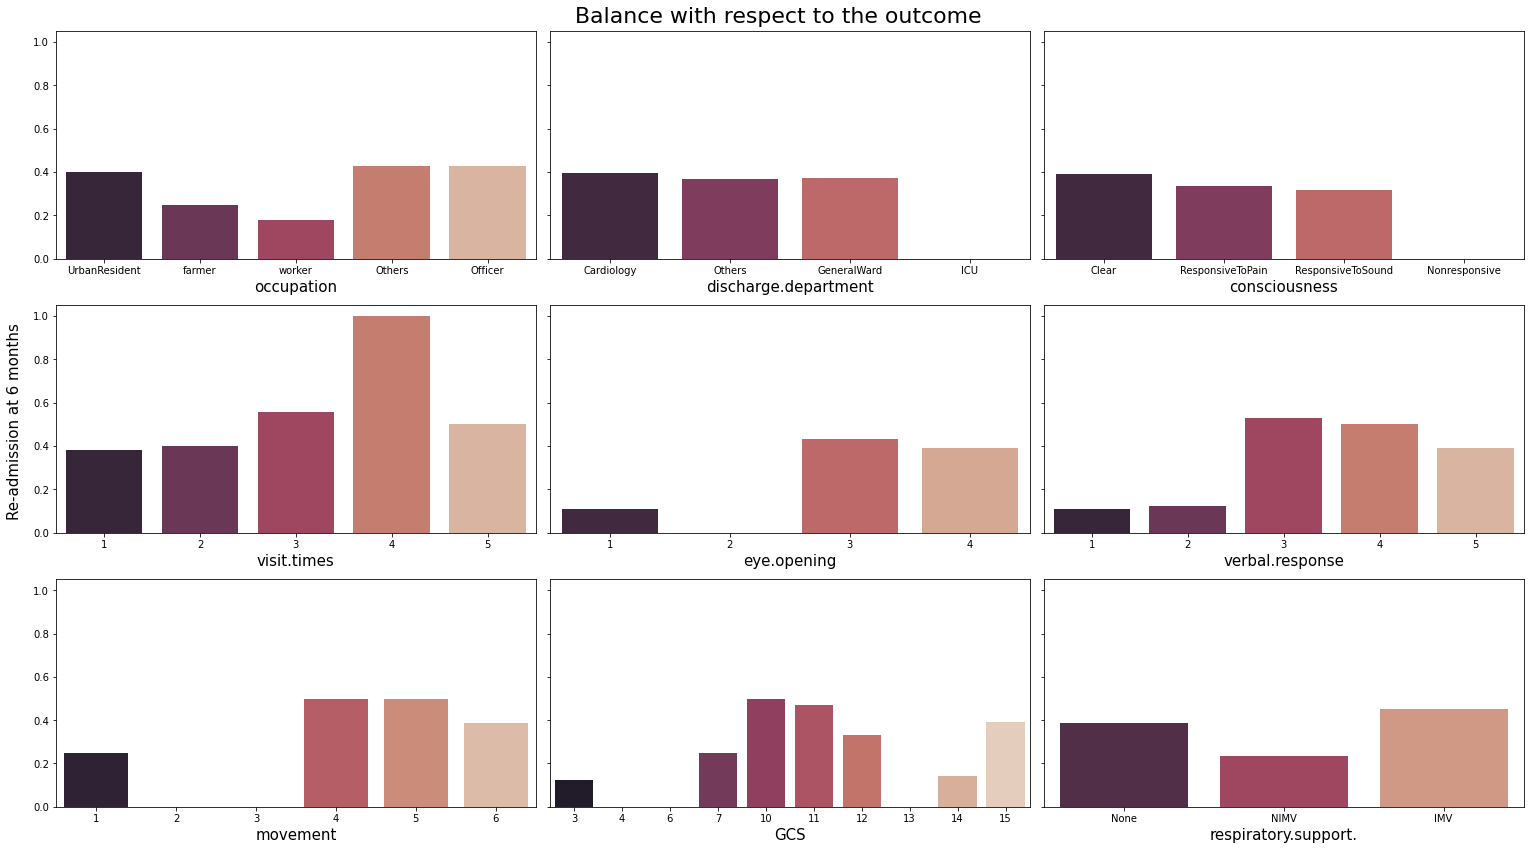

In [18]:
group1 = ['occupation', 'discharge.department', 'consciousness','visit.times', 'eye.opening', 
          'verbal.response','movement', 'GCS', 'respiratory.support.']

fig, axes = plt.subplots(3,3,sharey=True, figsize=(21,12))
fig.text(-0.01, 0.5, 'Re-admission at 6 months', va='center', rotation='vertical', size = 15)
fig.suptitle('Balance with respect to the outcome', size = 22)

idx = 0
i = 0
for column_name in group1:
    
    sns.barplot(ax=axes[i,idx], x=column_name, y= outcome_name,
                data=data, saturation=.5, ci=None, palette='rocket')
    axes[i,idx].set_ylabel('')
    axes[i,idx].set_xlabel(column_name, size = 15)
    idx += 1
    if idx == 3:
        idx = 0
        i += 1

fig.tight_layout()
plt.show()

From this, we can see that some of the variables like 'eye.opening', 'verbal.response', 'movement', 'GCS', 'discharge department','consciousness' have some categories which are never present when the outcome is. For this reason, we will keep them for the models we will develop.

In [19]:
balanced_in_outcome.extend(['occupation','visit.times','respiratory.support.'])

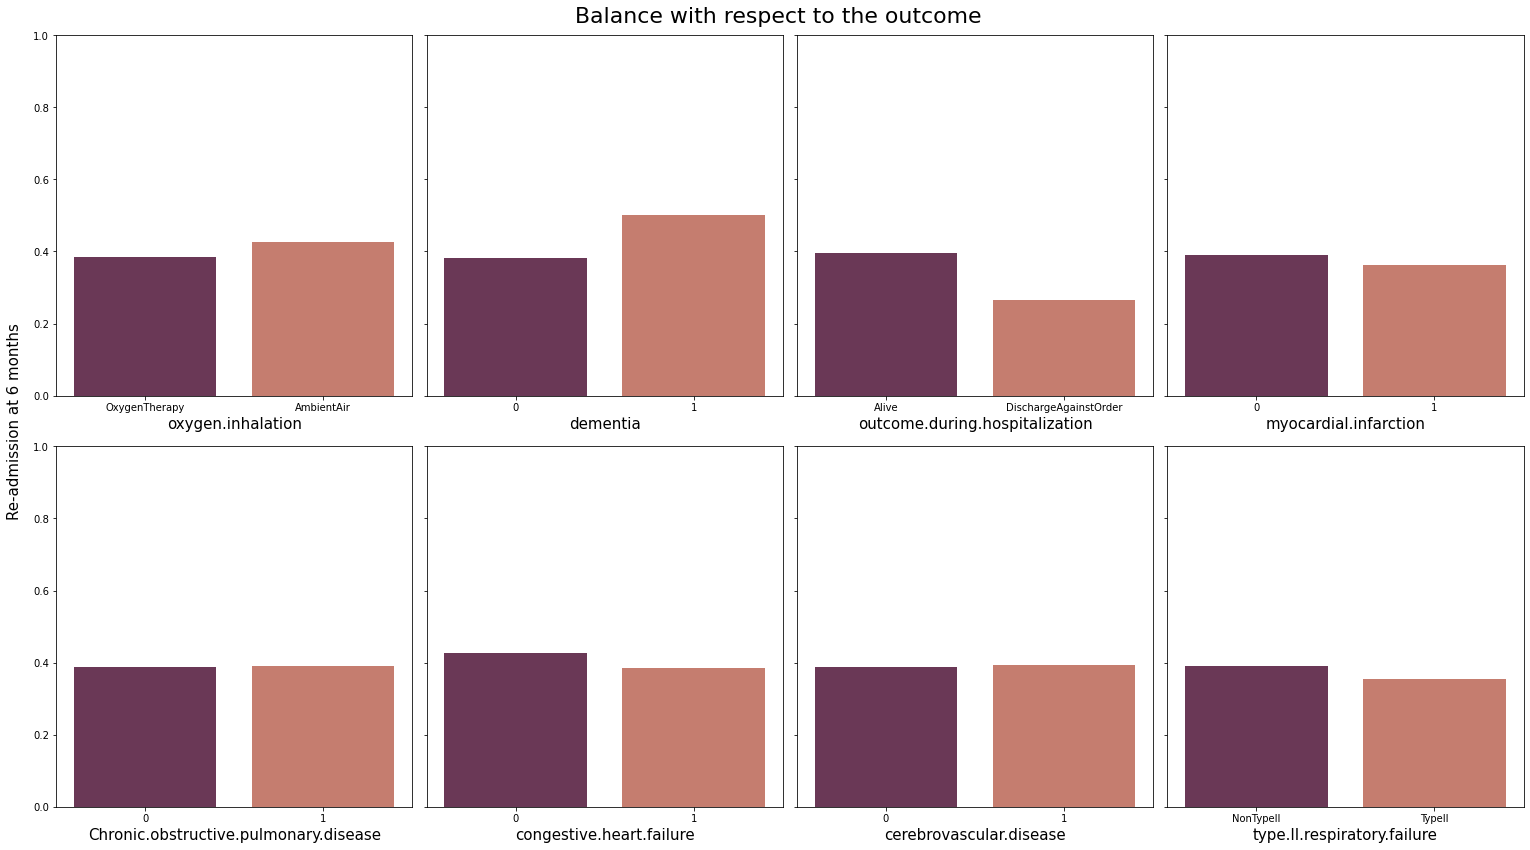

In [20]:
group2 = list(set(unbalanced_cols) - set(group1))

fig, axes = plt.subplots(2,4,sharey=True, figsize=(21,12))
fig.text(-0.01, 0.5, 'Re-admission at 6 months', va='center', rotation='vertical', size = 15)
fig.suptitle('Balance with respect to the outcome', size = 22)

idx = 0
i = 0
for column_name in group2:
    
    sns.barplot(ax=axes[i,idx], x=column_name, y= outcome_name,
                data=data, saturation=.5, ci=None, palette='rocket')
    axes[i,idx].set_ylabel('')
    axes[i,idx].set_xlabel(column_name, size = 15)
    idx += 1
    if idx == 4:
        idx = 0
        i += 1
        
plt.ylim([0,1])
fig.tight_layout()
plt.show()

We can see that all the binary variables have a balanced proportion of values in their categories corresponding to the outcome class. Thus, we can think of removing these variables from the study.

In [21]:
balanced_in_outcome.extend(group2)

In [22]:
data.drop(columns = balanced_in_outcome, inplace = True)
print(f"Current number of features: {data.shape[1]}")

Current number of features: 87


In [23]:
# now we should adjust the lists of variables 

categorical_columns = ['DestinationDischarge','admission.ward','admission.way','discharge.department',
                       'type.of.heart.failure', 'NYHA.cardiac.function.classification', 'Killip.grade',
                       'consciousness', 'ageCat']

ordinal_columns = ['CCI.score', 'eye.opening','verbal.response', 'movement', 'GCS']

not_continuous = categorical_columns.copy()

binary_columns = ['gender', 'diabetes', 'moderate.to.severe.chronic.kidney.disease',
                  're.admission.within.28.days', 're.admission.within.3.months', 
                  're.admission.within.6.months', 'return.to.emergency.department.within.6.months']

not_continuous.extend(binary_columns)
not_continuous.extend(ordinal_columns)

## One-hot encoding

In [24]:
# convert to categorical
cat_data = data[categorical_columns]
cat_data = pd.get_dummies(cat_data)

In [25]:
# not_cat should contain both continuous, binary and ordinal variables
not_cat = continuous_columns.copy()
not_cat.extend(binary_columns)
not_cat.extend(ordinal_columns)

data_new = data[not_cat].join(cat_data)
data_new  # data containing the dummies for algorithms

,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,BMI,fio2,left.ventricular.end.diastolic.diameter.LV,...,consciousness_ResponsiveToPain,consciousness_ResponsiveToSound,"ageCat_(21,29]","ageCat_(29,39]","ageCat_(39,49]","ageCat_(49,59]","ageCat_(59,69]","ageCat_(69,79]","ageCat_(79,89]","ageCat_(89,110]"
inpatient.number,,,,,,,,,,,,,,,,,,,,,
857781,36.7,87.0,19.0,102.0,64.0,76.666667,50.0,18.590125,33,NaN,...,0,0,0,0,0,0,0,1,0,0
743087,36.8,95.0,18.0,150.0,70.0,96.666667,51.0,19.195303,33,40.0,...,0,0,0,0,0,0,0,1,0,0
866418,36.5,98.0,18.0,102.0,67.0,78.666667,70.0,24.221453,33,46.0,...,0,0,0,0,0,0,1,0,0,0
775928,36.0,73.0,19.0,110.0,74.0,86.000000,65.0,22.491349,33,NaN,...,0,0,0,0,0,0,0,1,0,0
810128,35.0,88.0,19.0,134.0,62.0,86.000000,76.0,31.633715,33,64.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740689,36.1,117.0,22.0,120.0,80.0,93.333333,35.0,15.555556,33,NaN,...,0,0,0,0,0,0,0,0,1,0
734280,36.3,70.0,21.0,120.0,86.0,97.333333,50.0,20.811655,29,NaN,...,0,0,0,0,0,0,0,0,1,0
781004,36.8,113.0,19.0,135.0,100.0,111.666667,75.0,25.951557,33,NaN,...,0,0,0,0,1,0,0,0,0,0


In [26]:
print(f"Current number of features: {data_new.shape[1]}")

Current number of features: 112


## Binary variables to {0,1}

In [27]:
data['gender'].value_counts()

Female    1148
Male       822
Name: gender, dtype: int64

In [28]:
data_new['gender'] = [1 if elem=='Male' else 0 for elem in data['gender']]

In [29]:
# Convert CCI.score to int -- doesn't work
# data_new["CCI.score"].loc[data_new["CCI.score"].notnull()] = data["CCI.score"].loc[data["CCI.score"].notnull()].astype(int).values

# Continuous variables and correlation analysis

We will plot the correlation matrix just to have an idea of the possible groups of features that have a high (positive or negative) correlation. But clearly there are too many continuous variables to get a clear understading from this.

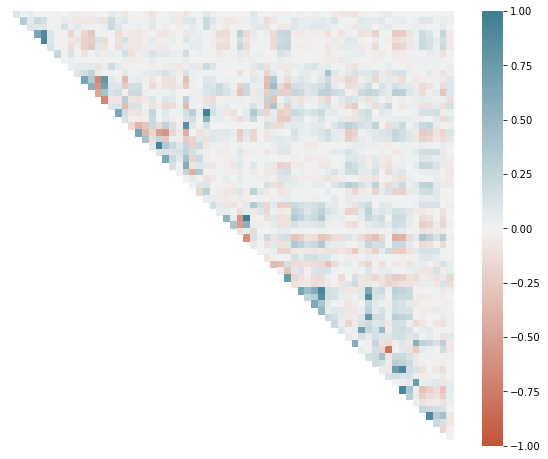

In [30]:
plt.figure(figsize=(10,8))
cor_matrix = data[continuous_columns].corr()

mask = np.tril(np.ones_like(cor_matrix, dtype=bool))
sns.heatmap(cor_matrix, mask = mask, xticklabels = False, yticklabels = False, vmin=-1, vmax=1, center = 0,
            cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

In [31]:
highly_corr_features = np.where(np.abs(cor_matrix) > 0.9)
coupled_features = zip(highly_corr_features[0],highly_corr_features[1])

ls = []
ls_names = []
# list of tuples of correlated features -- recover the names from correlation matrix
for elem1,elem2 in coupled_features:
    # exclude the couples with the same feature (corr = 1) and the couple already present in the list
    if elem1 != elem2 and (elem2,elem1) not in ls:
        ls.append((elem1,elem2))
        ls_names.append((cor_matrix.iloc[:,elem1].name,cor_matrix.iloc[:,elem2].name))

In [32]:
ls

[(4, 5), (15, 29), (20, 22), (31, 35), (42, 46), (54, 58), (57, 58)]

In [33]:
ls_names

[('diastolic.blood.pressure', 'map'),
 ('white.blood.cell', 'neutrophil.count'),
 ('mean.corpuscular.volume', 'mean.hemoglobin.volume'),
 ('international.normalized.ratio', 'prothrombin.time.ratio'),
 ('hydroxybutyrate.dehydrogenase', 'lactate.dehydrogenase'),
 ('indirect.bilirubin', 'total.bilirubin'),
 ('direct.bilirubin', 'total.bilirubin')]

### Analysis of the highly correlated features:

We analyse the highly correlated features and decide which ones to drop.

In [34]:
col_to_drop = []

In [35]:
plt.figure(figsize=(10,8))
cor_matrix = data.loc[:,['diastolic.blood.pressure', 'map']].corr()
cor_matrix

,diastolic.blood.pressure,map
diastolic.blood.pressure,1.00000,0.92299
map,0.92299,1.00000


<Figure size 720x576 with 0 Axes>

We keep the feature 'diastolic.blood.pressure' since the 'map' (Mean Arterial Pressure) synthesises the systolic and dyastolic blood pressures and so we already have this information.

In [36]:
col_to_drop = ['map']

In [37]:
cor_matrix = data.loc[:,['white.blood.cell', 'neutrophil.count']].corr()
cor_matrix

,white.blood.cell,neutrophil.count
white.blood.cell,1.000000,0.975443
neutrophil.count,0.975443,1.000000


We take 'white.blood.cell' since we have already a variable that rapresent the neutrophil rate.

In [38]:
col_to_drop.append('neutrophil.count')

In [39]:
cor_matrix = data.loc[:,['mean.corpuscular.volume', 'mean.hemoglobin.volume']].corr()
cor_matrix

,mean.corpuscular.volume,mean.hemoglobin.volume
mean.corpuscular.volume,1.000000,0.940756
mean.hemoglobin.volume,0.940756,1.000000


We take 'mean.corpuscular.volume' since it has a better distribution as we can see in the file 1_Data processing and cleaning

In [40]:
col_to_drop.append('mean.hemoglobin.volume')

In [41]:
cor_matrix = data.loc[:,['international.normalized.ratio', 'prothrombin.time.ratio']].corr()
cor_matrix

,international.normalized.ratio,prothrombin.time.ratio
international.normalized.ratio,1.00000,0.99707
prothrombin.time.ratio,0.99707,1.00000


We take 'prothrombin.time.ratio' since the 'international.normalized.ratio' is calculated from the other one.

In [42]:
col_to_drop.append('international.normalized.ratio')

In [43]:
cor_matrix = data.loc[:,['hydroxybutyrate.dehydrogenase', 'lactate.dehydrogenase']].corr()
cor_matrix

,hydroxybutyrate.dehydrogenase,lactate.dehydrogenase
hydroxybutyrate.dehydrogenase,1.000000,0.921141
lactate.dehydrogenase,0.921141,1.000000


La 3-idrossibutirrato deidrogenasi è un enzima appartenente alla classe delle ossidoreduttasi, che catalizza la seguente reazione:

(D)-3-idrossibutanoato + NAD+ ⇄ acetoacetato + NADH + H+

La L-lattato deidrogenasi (o LDH) è un enzima, appartenente alla classe delle ossidoreduttasi, che catalizza la seguente reazione:

(L)-lattato + NAD+ ⇄ piruvato + NADH + H+

We notice that these two enzymes catalyze indeed very similar chemical reactions, so we can explain ourselves the big correlation between the two. We decide to keep only the lactate.dehydrogenase.

In [44]:
col_to_drop.append('hydroxybutyrate.dehydrogenase')

In [45]:
cor_matrix = data.loc[:,['indirect.bilirubin', 'total.bilirubin']].corr()
cor_matrix

,indirect.bilirubin,total.bilirubin
indirect.bilirubin,1.000000,0.927012
total.bilirubin,0.927012,1.000000


In [46]:
cor_matrix = data.loc[:,['direct.bilirubin', 'total.bilirubin']].corr()
cor_matrix

,direct.bilirubin,total.bilirubin
direct.bilirubin,1.000000,0.931469
total.bilirubin,0.931469,1.000000


We take the 'total.bilirubin' since is the sum of the indirect and direct bilirubin.

In [47]:
col_to_drop.append('direct.bilirubin')
col_to_drop.append('indirect.bilirubin')

#### We drop the column that are correlated

In [48]:
data_final = data_new.copy()
data_final.drop(col_to_drop, axis=1, inplace = True)
print(f"Current number of features: {data_final.shape[1]}")

Current number of features: 105


In [49]:
data_final.to_csv('data_cleaned.csv')